f=1, g=0, crack: 0 degrees

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# -laplace u = 1 in [-1,1]^2 \ {(x,0), x in [0,1]}
# Settings 
torch.set_default_dtype(torch.float64)   # use double for better derivative precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain: square [-1,1]^2 with crack along y=0 for x in [0,1)
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0

# Training hyperparams
N_f = 4000       # collocation points
N_b_outer = 800  # boundary points on outer square
N_b_crack = 300  # boundary points on crack 
epochs = 10000
lr = 1e-3
lambda_bc = 1.0   # weight for BC loss

# ---- Utility functions ----
def compute_phi(x, y):
    r = torch.sqrt(x**2 + y**2)
    return torch.sqrt(0.5 * (r - x))


def compute_phi_derivs(x, y):
    r = torch.sqrt(x**2 + y**2)
    #phi_x = (-0.5) * (0.5**0.5) * torch.sqrt(r - x) / r
    phi_x = (0.25) * (2**0.5) * (x/r -1)/ torch.sqrt(r - x)
    #phi_y = (0.5)  * (0.5**0.5) * torch.sqrt(r + x) / r
    phi_y = (0.25) * (2**0.5) * (y/r)/ torch.sqrt(r - x)

    return phi_x.reshape(-1,1), phi_y.reshape(-1,1)

# Neural network 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)  # no activation on last
        return z
    
  # Derivative
def partials_U_wrt_inputs(model, x, y, phi):
    phi_det = phi.detach()  # 固定phi值，不會亂動？？
    inp = torch.cat([x, y, phi_det], dim=1).to(device) 
    inp.requires_grad_(True) # 追蹤x,y,phi，到時候要算Ｕ對這三個的微分

    U = model(inp)  # (N,1) 把x,y,phi丟進去，算出U

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U), create_graph=True, retain_graph=True)[0]  # (N,3)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]
    return U, inp, U_x, U_y, U_z

def second_partials_U(model, inp, U_x, U_y, U_z):
    # 舉例：grad_Ux = [U_xx, U_xy, U_xz], size 是 N*3
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x), create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y), create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z), create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1] #取第1個column
    #U_xy = grad_Ux[:,1:2] #取第2個column
    U_xz = grad_Ux[:,2:3] #取第3個column

    #U_yx = grad_Uy[:,0:1]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]

    #U_zx = grad_Uz[:,0:1]
    #U_zy = grad_Uz[:,1:2]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_laplace_uN(model, x, y):
    phi = compute_phi(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)
    laplace_xU = U_xx + U_yy
    r = torch.sqrt(x**2 + y**2)
    #lap = laplace_xU + (0.5**0.5) / r * (torch.sqrt(r-x)* -U_xz + torch.sqrt(r+x)*U_yz) + (1/(4*r))*U_zz
    lap = laplace_xU + (0.5**0.5) / torch.sqrt(r-x) * ((x/r -1) * U_xz + (y/r) * U_yz) + (1/(4*(r-x)) *(1-(x/r)) )*U_zz

    return lap  # shape (N,1)

 # Data sampling 
def sample_collocation(N):
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN
    mask_crack = (torch.abs(y) < 1e-8) & (x >= 0.0)  # remove points on crack
    mask = ~mask_crack
    x = x[mask][:N]
    y = y[mask][:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []
    # left (x=-1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MIN)
    # right (x=1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MAX)
    # bottom (y=-1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    # top (y=1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_crack_boundary(N):
    # 在 0 < x <= 1 取 N 個均勻點，避開 x=0
    x_vals = torch.linspace(0, 1, N + 1)[1:].unsqueeze(1).to(device)  # x=0 不取
    y_vals = torch.zeros_like(x_vals).to(device)  # y=0

    return x_vals, y_vals


# model
layers = [3, 64, 1]  
model = MLP(layers).to(device)

# Training data 
x_f, y_f = sample_collocation(N_f)
x_b_out, y_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack = sample_crack_boundary(N_b_crack)

# boundary values
with torch.no_grad(): # no computation graph，不會把計算過程放到計算圖中（？？？），節省資源
    g_b_out = torch.zeros_like(x_b_out, device=device)
    g_b_crack = torch.zeros_like(x_b_crack, device=device)
# concatenate all boundary points
x_b = torch.cat([x_b_out, x_b_crack], dim=0) # 把x_b_out和x_b_crack兩個向量拼成一個向量
y_b = torch.cat([y_b_out, y_b_crack], dim=0)
g_b = torch.cat([g_b_out, g_b_crack], dim=0)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

# Training loop
print("Start training on device:", device)
for ep in range(epochs):
    optimizer.zero_grad()
    # PDE loss
    lap_u = compute_laplace_uN(model, x_f, y_f)  # shape (N_f,1)
    residual = -lap_u -1.0  # f=1
    loss_pde = torch.mean(residual**2)

    # boundary loss
    phi_b = compute_phi(x_b, y_b)
    inp_bc = torch.cat([x_b, y_b, phi_b.detach()], dim=1)
    u_bc = model(inp_bc)
    loss_bc = torch.mean((u_bc - 0.0)**2)

    loss = loss_pde + lambda_bc * loss_bc
    loss.backward()
    optimizer.step()

    # 紀錄 loss
    loss_history.append(loss.item())

    if ep % 200 == 0 or ep == epochs-1:
        print(f"Epoch {ep:5d} | Loss {loss.item():.3e} | PDE {loss_pde.item():.3e} | BC {loss_bc.item():.3e}")

print("Training finished.")

Start training on device: cpu
Epoch     0 | Loss 1.115e+00 | PDE 1.044e+00 | BC 7.044e-02
Epoch   200 | Loss 2.758e-02 | PDE 2.530e-02 | BC 2.286e-03
Epoch   400 | Loss 9.190e-03 | PDE 7.387e-03 | BC 1.803e-03
Epoch   600 | Loss 6.957e-03 | PDE 5.122e-03 | BC 1.834e-03
Epoch   800 | Loss 5.996e-03 | PDE 4.147e-03 | BC 1.849e-03
Epoch  1000 | Loss 5.382e-03 | PDE 3.510e-03 | BC 1.872e-03
Epoch  1200 | Loss 4.922e-03 | PDE 3.028e-03 | BC 1.894e-03
Epoch  1400 | Loss 4.550e-03 | PDE 2.629e-03 | BC 1.920e-03
Epoch  1600 | Loss 4.233e-03 | PDE 2.284e-03 | BC 1.949e-03
Epoch  1800 | Loss 3.962e-03 | PDE 1.991e-03 | BC 1.972e-03
Epoch  2000 | Loss 3.733e-03 | PDE 1.751e-03 | BC 1.982e-03
Epoch  2200 | Loss 3.535e-03 | PDE 1.556e-03 | BC 1.979e-03
Epoch  2400 | Loss 3.360e-03 | PDE 1.393e-03 | BC 1.967e-03
Epoch  2600 | Loss 3.203e-03 | PDE 1.255e-03 | BC 1.948e-03
Epoch  2800 | Loss 3.062e-03 | PDE 1.135e-03 | BC 1.926e-03
Epoch  3000 | Loss 2.935e-03 | PDE 1.032e-03 | BC 1.903e-03
Epoch  320

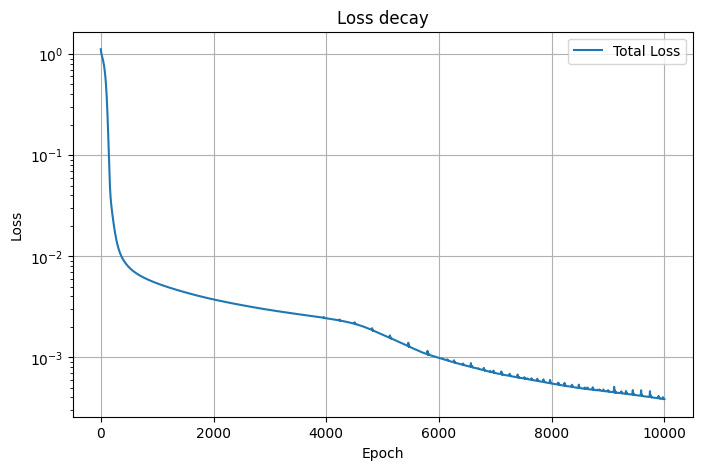

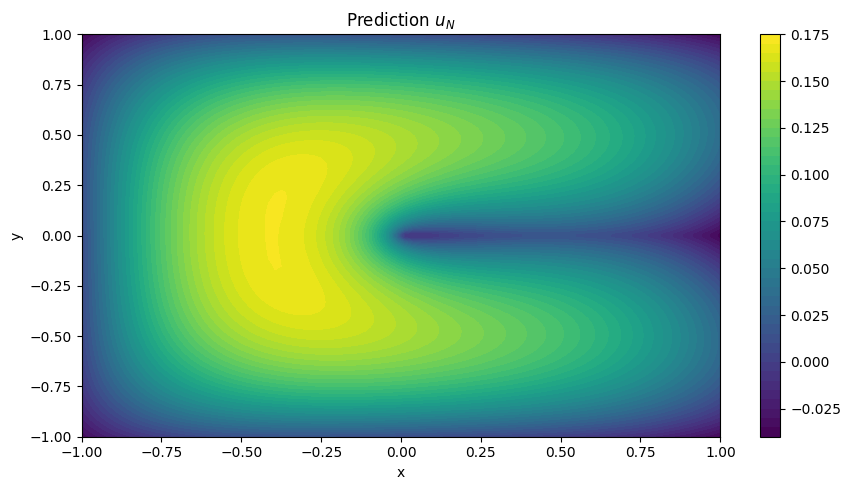

In [2]:
# 畫 Loss
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss decay")
plt.grid(True)
plt.show()

# 測試網格
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)
x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()

# phi(grid)
with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid)

# 預測解
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

# 畫圖 
fig, ax = plt.subplots(figsize=(9,5))  

im0 = ax.contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=ax)
ax.set_title('Prediction $u_N$')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
plt.show()